[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six

from collections import Counter, OrderedDict
from radiomics import featureextractor
from scipy import stats
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

scaler = StandardScaler()
pca = PCA(n_components='mle')
tsne = TSNE(learning_rate='auto', init='pca', random_state=0)

# Display Tools

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s (%s): %i (%.2f%%)" %
              (k, colormap.colors[k], c[k], c[k]*100/sum(c.values())))
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=1)
    plt.show()
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=150)

def display_tsne(df):
    transformed = tsne.fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()


# Iteration Logic

In [3]:
def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, params, mode="thresh_adaptive", verbose=False):
    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        hist1 = cv2.calcHist([image], [0], None, [256], [0,256])
        ax1.plot(hist1)
        ax1.set_title("Raw Image")
        ax1.set_xlim([0,256])
        ax1.set_ylim([0,hist1.max()])

    if params['denoise_pre']:
        image = apply_denoise(image, params['denoise_pre'])

    if params['contrast']:
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        enhanced = np.uint8(np.clip((params['contrast']*(np.float64(image)-peak)) + peak,
                                    0, 255))
    
    if params['clipLimit']:
        image = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
    
    if params['denoise_post']:
        image = apply_denoise(image, params['denoise_post'])
        
    if mode == "background_filter":
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        binarized = np.uint8((image < peak - params['lower_width']) | \
                             (image > peak + params['upper_width']))
    elif mode == "edge_canny":
        image = apply_sharpen(image)
        binarized = apply_canny(image, params['threshold1'], params['threshold2'])
    elif mode == "edge_sobel":
        image = apply_sharpen(image)
        sobel = apply_sobel(image, params['sobel_ks'])
        _, binarized = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif mode == "kmeans":
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, _ = cv2.kmeans(np.float32(raw_image.flatten()), 2, None, criteria,
                       params['attempts'], cv2.KMEANS_PP_CENTERS)
        binarized = np.uint8(labels.reshape(image.shape))
        if stats.mode(labels.flatten()).mode[0]:
            binarized = cv2.bitwise_not(binarized)
    elif mode == "thresh_adaptive":
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    elif mode == "thresh_otsu":
        _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        print("Invalid mask mode, aborting.")
        return None
    
    filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))
    
    if verbose:
        ax2.plot(cv2.calcHist([image], [0], None, [256], [0,256]))
        ax2.set_title("Preprocessed")
        ax2.set_xlim([0,256])
        ax2.set_ylim([0,hist1.max()])

        display_image_array([image, binarized, filled],
                            ["Preprocessed", "Binarized", "Filled"], columns=3, dpi=450)

    return filled

def process_features(df):
    return pd.DataFrame(pca.transform(scaler.transform(df.values)),
                        index=df.index)

# Image preprocessing parameters

In [4]:
mode = "thresh_adaptive"

params = {
    ##################################################
    ###### PREPROCESSING #############################
    ### set to 0 to disable ##########################

    'denoise_pre': 0,
    
    # background separation
    'contrast': 1.5,  # contrast boosting factor

    # histogram equalization
    'clipLimit': 0,  # contrast limit for clipping
    
    'denoise_post': 3,

    ##################################################

    ##################################################
    ###### BINARIZATION MODE #########################
    ### set `mode` to one of the following ###########
    ### other params will be ignored #################

    # "background_filter"
    'lower_width': 10,  # distances from peak
    'upper_width': 10,
    
    # "edge_canny"
    'threshold1': 30,  # lower values are ignored
    'threshold2': 210, # middle values considered if
                       # connected to upper values
    
    # "edge_sobel"
    'sobel_ks': 5,
    
    # "kmeans"
    'attempts': 10,  # number of times to repeat
    
    # "thresh_adaptive"
    'thresh_ks': 151,
    'C': 8,
    
    # "thresh_otsu"
    # No params needed

    ##################################################
    
    # image closure kernel size
    'closure_ks': 3,
}

# Fit and classify on control image

## Create mask image and extract raw features

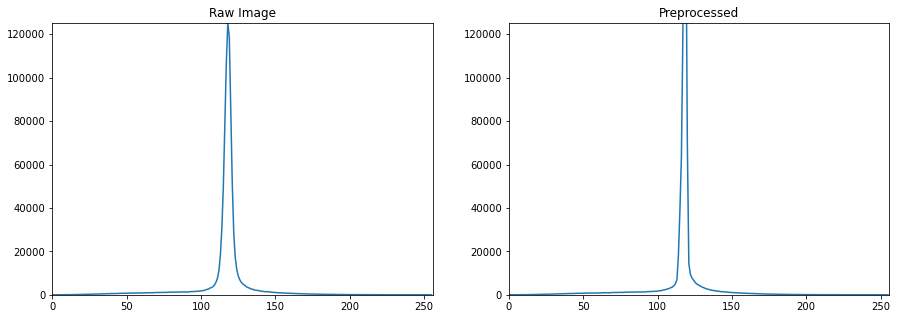

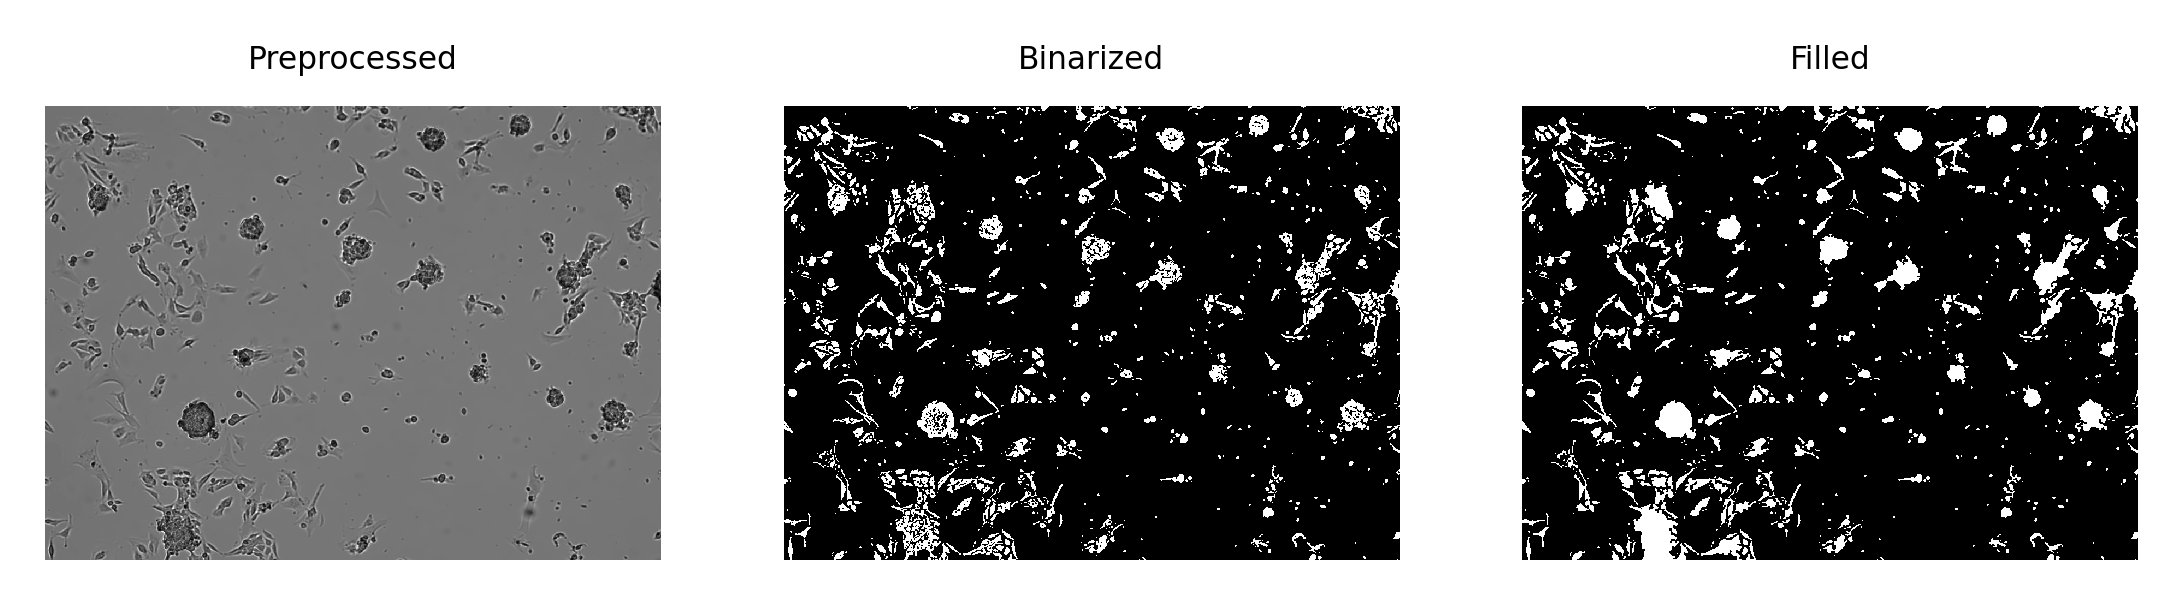

,,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile,...,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
x,y,,,,,,,,,,,,,,,,,,,,,
476,3,0.639776,15.237390,16.76305461424021,103.5,9.748512,43.7989898732233,0.4231786461180995,104.0,0.823400,43.3,...,36.44230769230769,0.5790495562130178,5.259615384615385,28.75,145.35576923076923,10.640558226495727,0.3574385683760684,0.08286322363703316,0.5611805010465725,0.02233250483043803
541,14,0.512280,31.564171,30.01666203960727,329.5,16.169707,88.18376618407362,0.2676290324251096,330.0,0.729699,42.0,...,91.63030303030303,1.0048209366391185,12.015151515151516,26.12121212121212,282.3363636363636,3.391738215488215,0.12588468013468013,0.1096815924742512,1.7424555690121166,0.010296287880908693
575,3,0.407083,24.662635,25.317977802344327,180.5,10.039748,65.79898987322329,0.3645373400178576,181.0,0.723810,54.0,...,73.47513812154696,0.5039528707914899,6.685082872928176,31.740331491712706,173.2596685082873,7.063382443216697,0.21408839779005526,0.09794450238659,0.8998508068052267,0.016887917139947854
621,7,0.813564,15.754650,16.15549442140351,151.5,12.817416,50.62741699796948,0.33417436962356095,152.0,0.861838,32.0,...,44.5921052631579,0.9705245844875345,9.388157894736842,20.526315789473685,144.40131578947367,4.067788742690058,0.17836622807017544,0.13952426846713342,1.808176923790959,0.02021936098772477
753,2,0.196289,32.170366,30.805843601498726,119.5,6.314693,69.4558441227157,0.5812204529097549,120.0,0.557930,37.0,...,40.05,0.749375,7.125,24.35,150.875,7.895833333333333,0.2777777777777778,0.09563272785966238,0.8361451653964055,0.01819884800199229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,814,0.647466,40.571514,39.824615503479755,337.5,26.268692,166.9533188057743,0.4946765001652572,338.0,0.390074,28.700000000000003,...,74.27810650887574,1.5636094674556211,11.754437869822485,14.248520710059172,126.69526627218934,3.113032494062714,0.18887897663996564,0.21523604905473034,3.647510025459888,0.02923444940243246
177,810,0.459414,22.767687,25.553864678361276,178.5,10.459784,67.35533905932733,0.3773408350662596,179.0,0.703157,51.0,...,60.93296089385475,0.6559096158047502,7.346368715083799,23.93854748603352,160.81005586592178,5.293102110490379,0.2337445685909373,0.1512796862485942,1.668931461318233,0.026679200029668164
407,815,0.585126,14.952231,15.033296378372908,98.5,8.748934,41.798989873223306,0.4243552271393229,99.0,0.841700,77.0,...,61.62626262626262,0.21997755331088664,4.6767676767676765,42.07070707070707,173.36363636363637,10.605499438832771,0.2716049382716049,0.1114412549531597,0.8034810691953549,0.026154209485889382


In [5]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode, verbose=True)
df, masks = extract_features(raw_image, mask_image)
display(df)

## Scale features and reduce dimensions

In [6]:
scaler.fit(df.values)
pca.fit(df.values)

df = process_features(df)
display(df)

,,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
x,y,,,,,,,,,,,,,,,,,,,,,
476,3,-4.317736e+06,-5974.389969,-5039.236636,71.206135,36.533741,-463.102961,57.964021,-132.376593,160.089958,42.148683,...,0.468126,0.063673,0.658247,0.791261,-0.779158,-0.156933,0.876367,-0.327554,0.930563,0.182439
541,14,-4.317735e+06,-5974.392137,-5039.157672,71.484776,36.385323,-461.914868,58.281879,-131.431120,158.390592,41.624593,...,0.464872,0.855304,-0.016527,0.923554,0.008205,-1.046095,0.300373,-0.096251,1.350564,0.253312
575,3,-4.317736e+06,-5974.391253,-5039.294394,71.225357,36.414417,-463.195739,58.187410,-132.061964,159.546520,42.104006,...,0.456992,0.442587,0.367012,0.753849,-0.593870,-0.715457,0.922708,-0.449680,0.897752,0.174228
621,7,-4.317736e+06,-5974.394130,-5039.467197,71.530058,36.519646,-462.142689,57.966955,-132.425908,159.982294,42.240173,...,0.543831,0.523331,-0.114609,1.533988,-0.839462,-0.603410,0.206626,-0.218027,1.653513,0.312054
753,2,-4.317736e+06,-5974.393612,-5039.434631,71.503345,36.529350,-462.510345,57.858463,-132.130217,159.576119,42.354547,...,0.299866,0.683505,0.400501,0.880344,-0.771555,-0.502908,0.399244,-0.429196,1.193592,0.225589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,814,-4.317735e+06,-5974.395635,-5039.549450,71.749631,36.557475,-460.725979,58.343320,-132.007732,159.197340,43.254348,...,0.380632,-0.259650,-0.960673,1.928860,-0.639798,0.003438,-0.134861,0.154507,2.022162,0.384353
177,810,-4.317736e+06,-5974.393012,-5039.391851,71.403411,36.474763,-463.036173,58.147090,-132.168651,159.621194,42.253689,...,0.485071,-0.178228,-0.043312,1.378104,-1.284809,-0.321317,0.673710,-0.394170,1.337932,0.260928
407,815,-4.317736e+06,-5974.390296,-5039.288623,71.054357,36.376184,-464.140656,57.989886,-132.078556,159.722035,41.739067,...,0.666742,-0.401293,0.613030,0.374897,-0.881602,-0.222340,1.773331,-0.881896,0.349835,0.068268


## Determine number of clusters

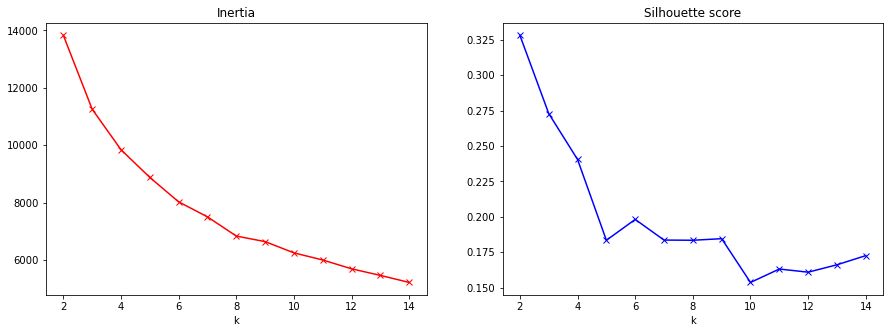

In [7]:
inertias = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette score")
plt.show()

### User-defined values

In [8]:
# Manually select k based on visual inspection above
k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

## Fit and classify using silhouette score

Class 0 (yellow): 89 (42.58%)
Class 1 (red): 18 (8.61%)
Class 2 (cyan): 70 (33.49%)
Class 3 (orange): 32 (15.31%)


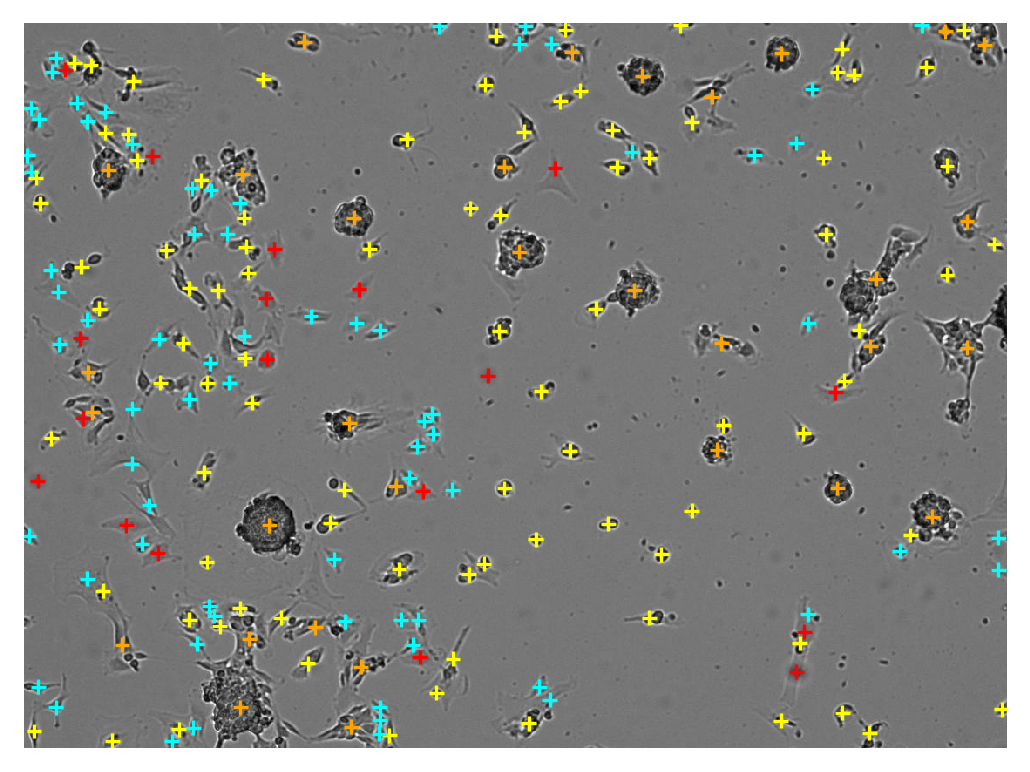

In [9]:
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 89 ROIs:


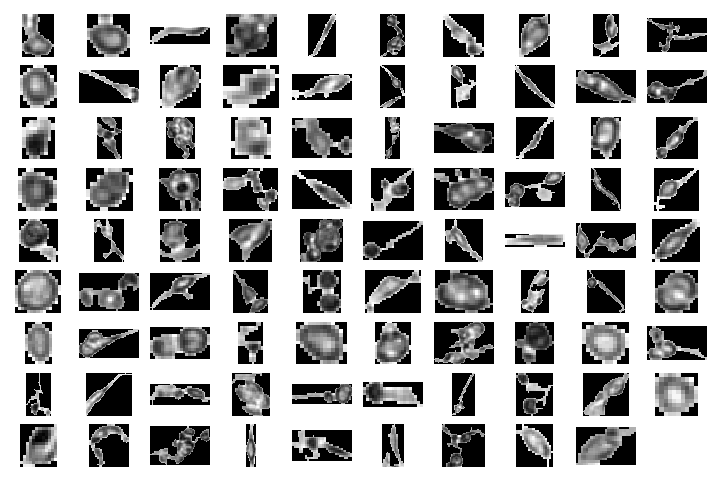

Class 1, with 18 ROIs:


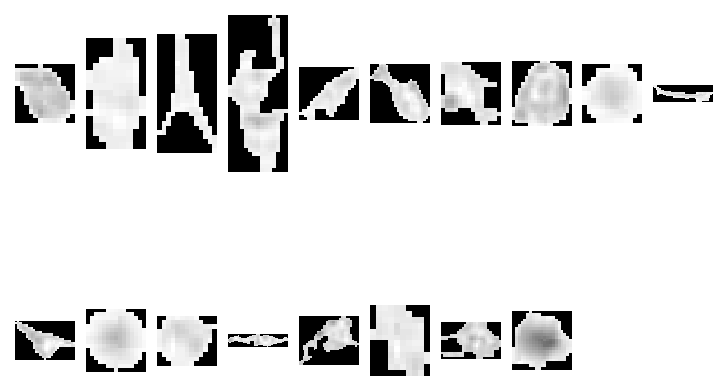

Class 2, with 70 ROIs:


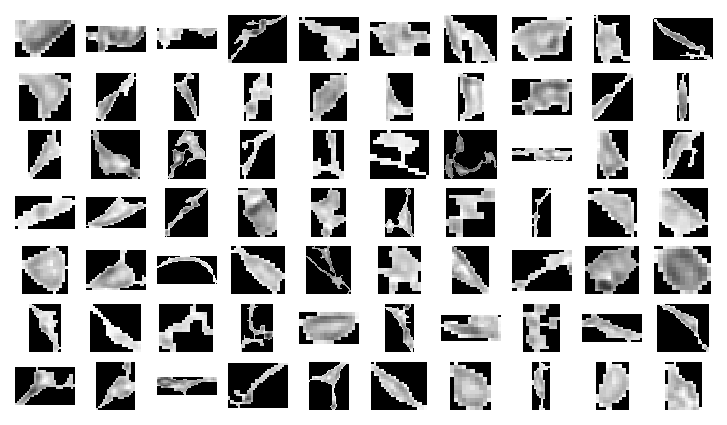

Class 3, with 32 ROIs:


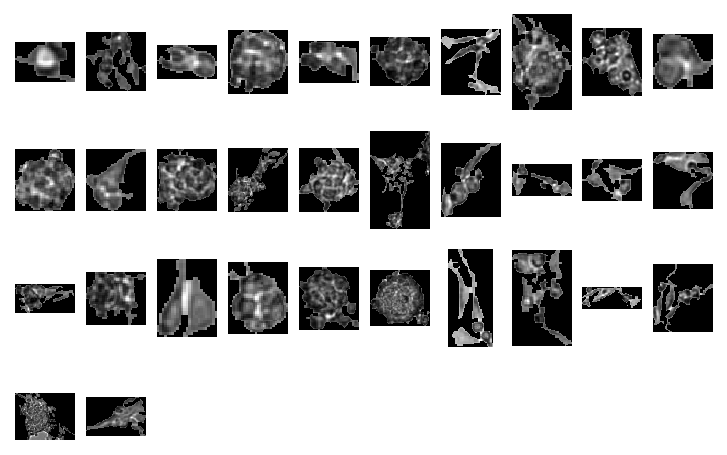

In [10]:
display_rois(raw_image, masks, labels)

## Cluster visualization

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


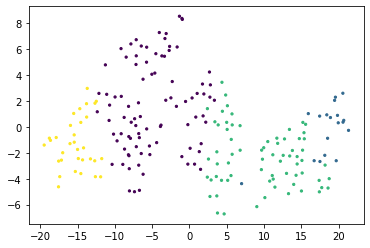

In [11]:
display_tsne(df)

# Experiment w/ multi-Otsu

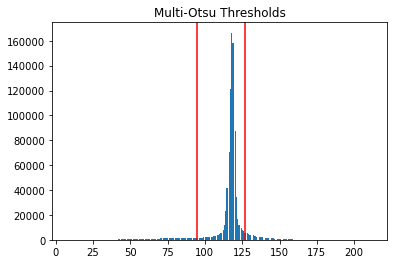

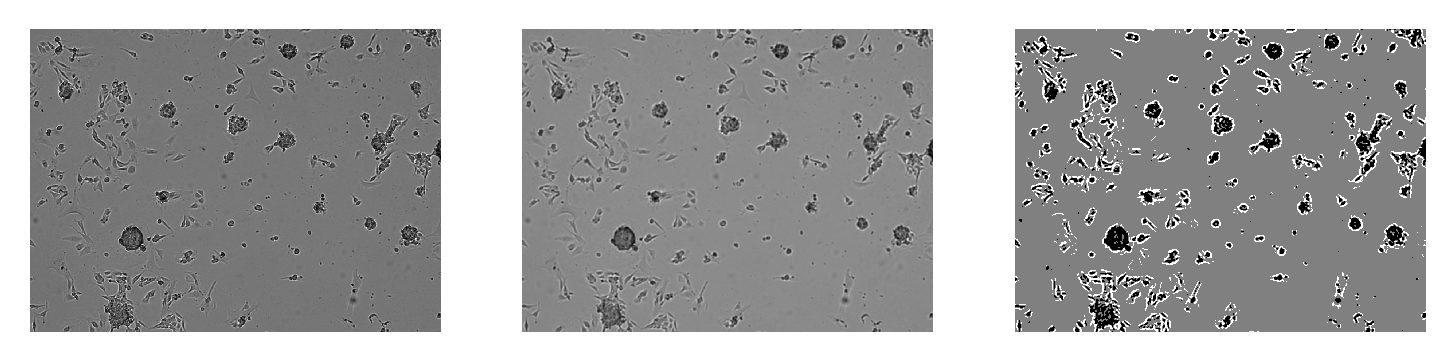

In [12]:
blurred = apply_blur(raw_image, 5)
thresholds = threshold_multiotsu(blurred)
multi_otsu_regions = np.digitize(blurred, bins=thresholds)

plt.hist(blurred.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, blurred, multi_otsu_regions],
                    columns=3, dpi=300)

# Classify cells on adherent image

Class 0 (yellow): 68 (40.72%)
Class 1 (red): 24 (14.37%)
Class 2 (cyan): 47 (28.14%)
Class 3 (orange): 28 (16.77%)


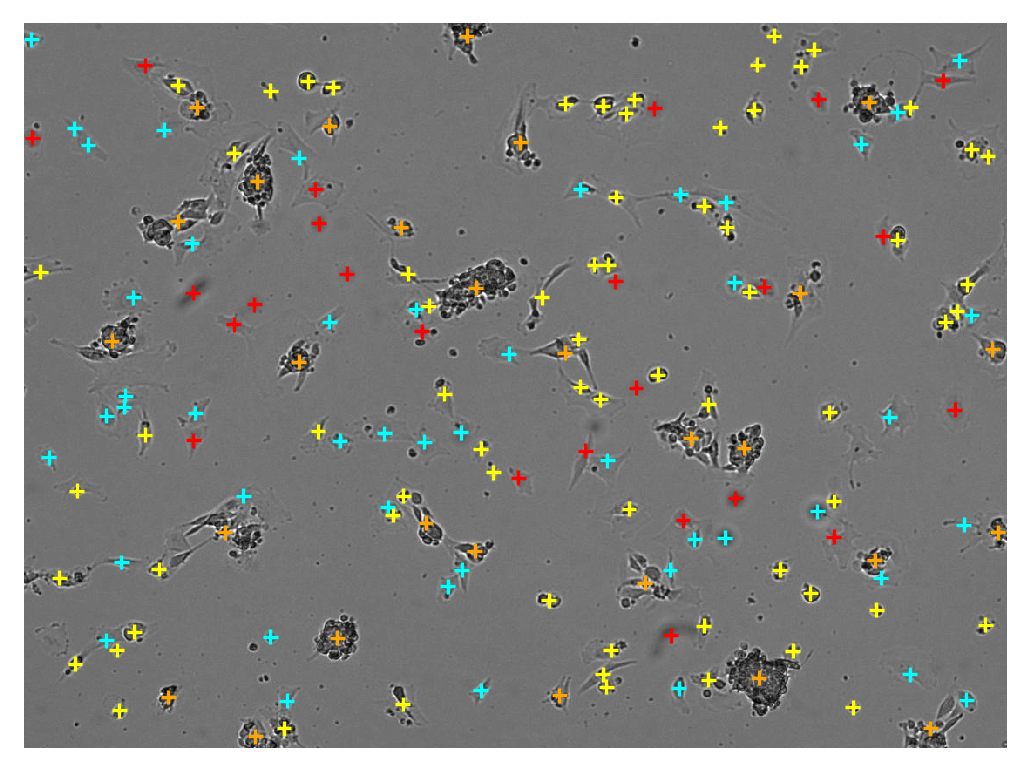

In [13]:
raw_image = cv2.imreadmulti('source_images/Adherent.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 68 ROIs:


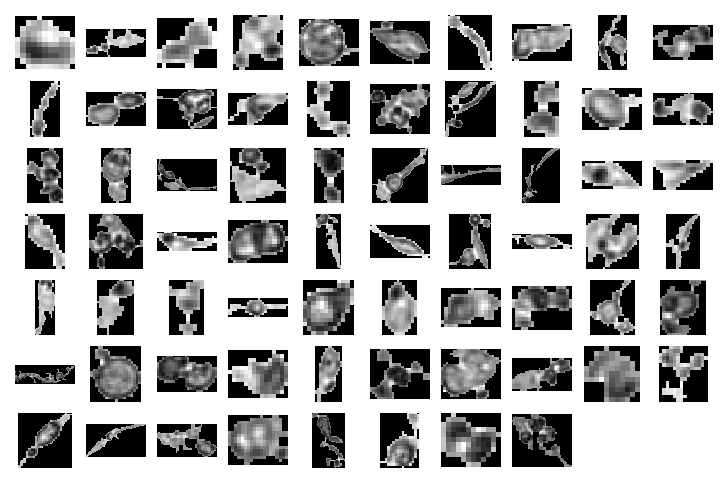

Class 1, with 24 ROIs:


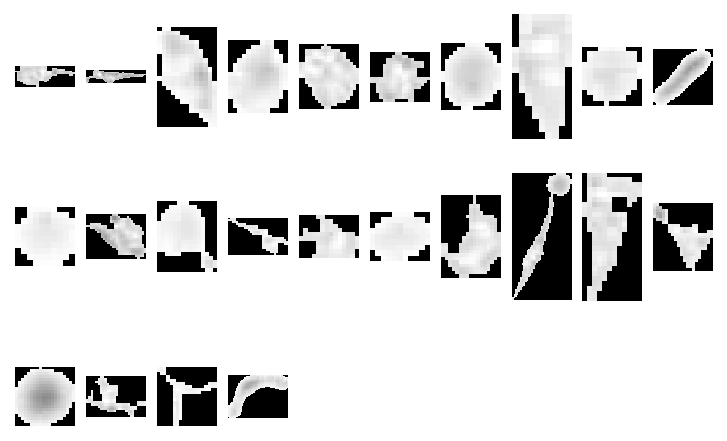

Class 2, with 47 ROIs:


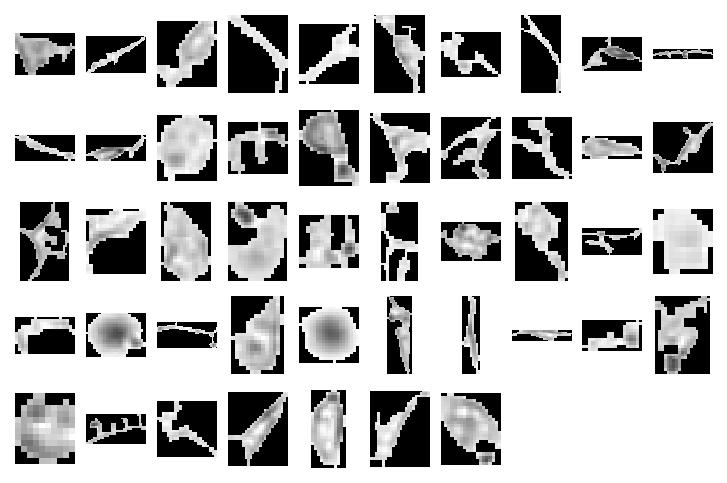

Class 3, with 28 ROIs:


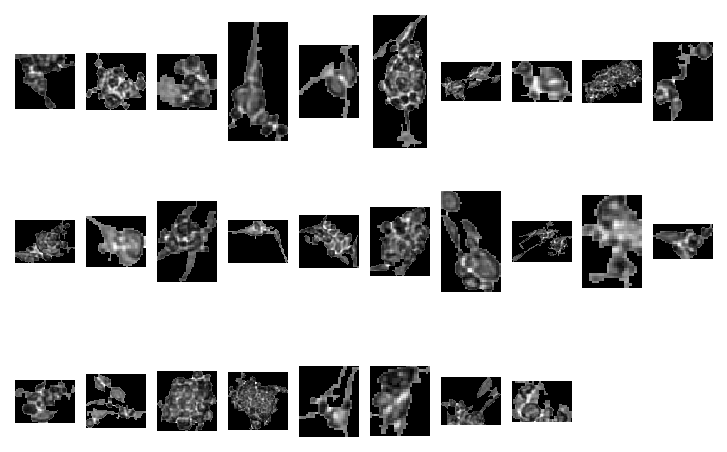

In [14]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


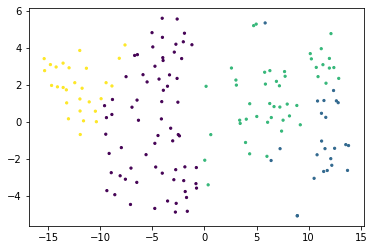

In [15]:
display_tsne(df)

# Classify cells on suspension image

Class 0 (yellow): 60 (37.50%)
Class 1 (red): 43 (26.88%)
Class 2 (cyan): 38 (23.75%)
Class 3 (orange): 19 (11.88%)


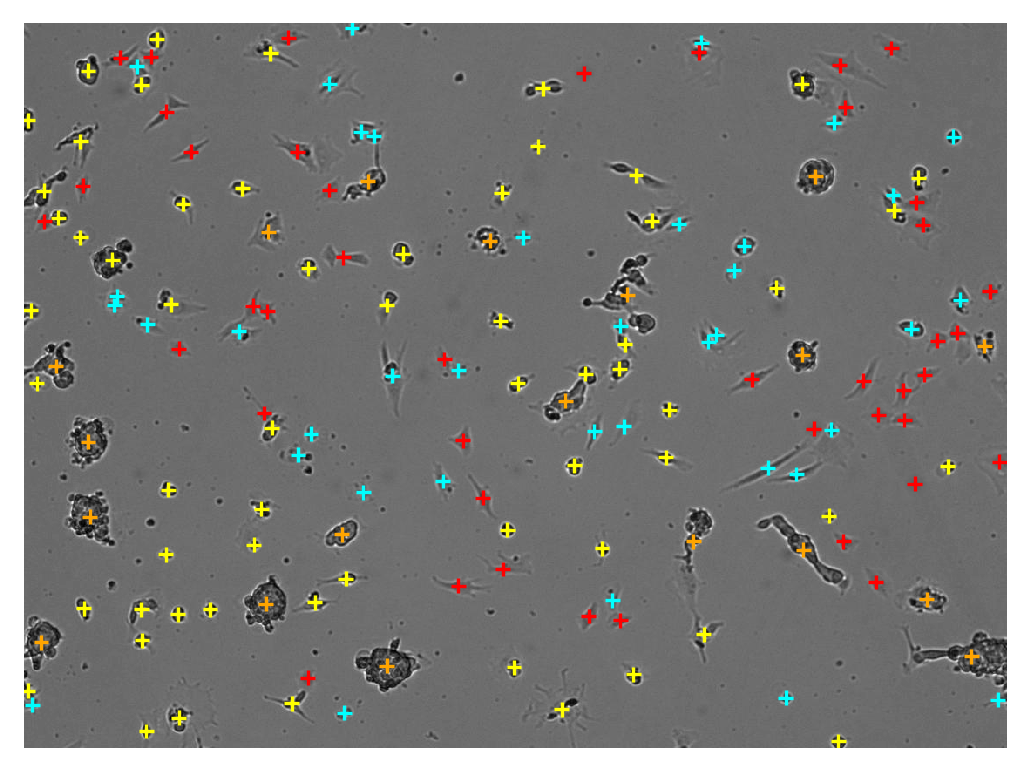

In [16]:
raw_image = cv2.imreadmulti('source_images/Suspension.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 60 ROIs:


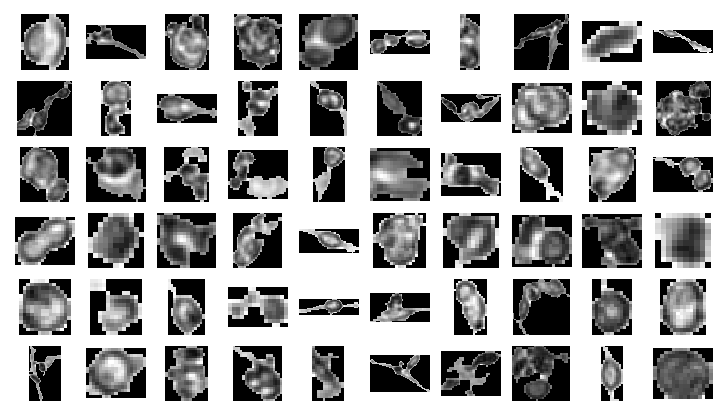

Class 1, with 43 ROIs:


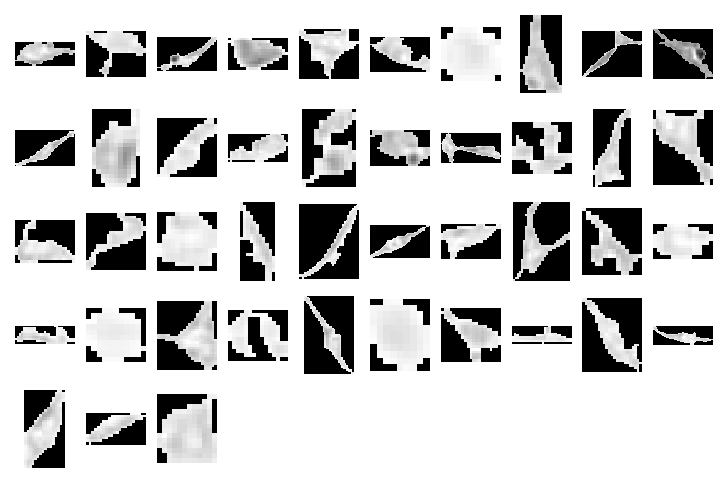

Class 2, with 38 ROIs:


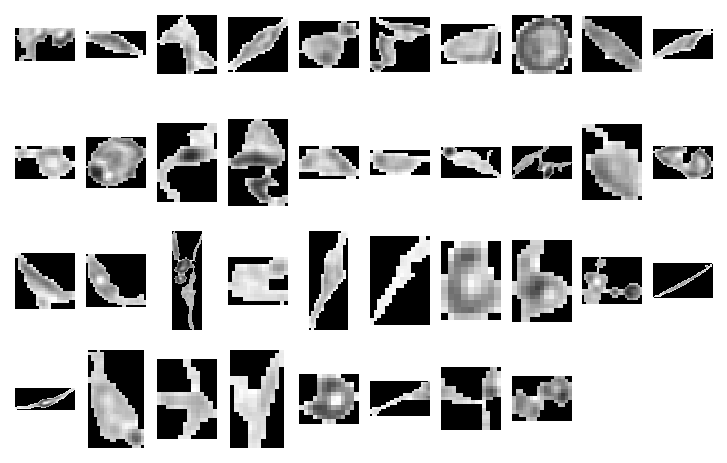

Class 3, with 19 ROIs:


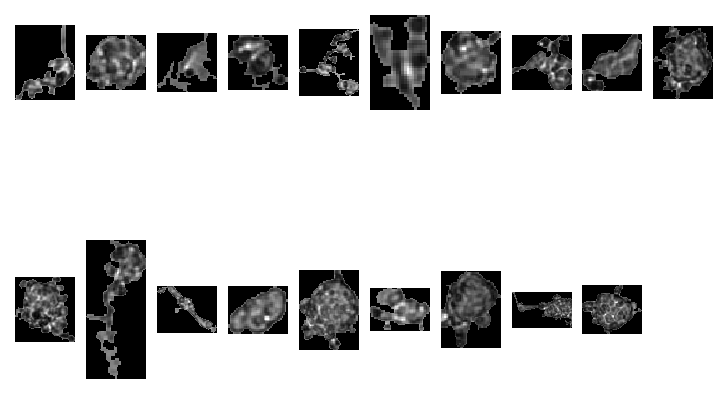

In [17]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


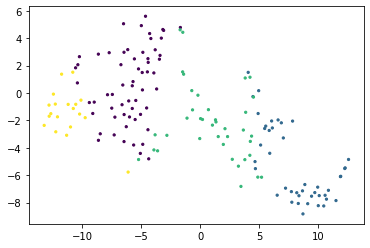

In [18]:
display_tsne(df)